# Building a credit derivatives compressor Open AI Gym environment

For my UROP project for the spring 2018 semester, I have created an Open AI Gym environment in an attempt to open the door for open source the problem of using reinforcement learning to build an automatic agent that finds the optimal policy for compressing a set of derivatives contracts between groups of banks. Given the recent resurgence of financial regulation incentivizing actors within the financial sector to minimize their excess derivative contract notional, devising an artificial intellegence system to automatically minimize this excess over time is certainly a worthwhile endevour.

## Problem Statement

Perhaps I should define the problem I intend to solve, before providing information about the artificial intelligence mechanisms I used to achieve a solution. In this notebook, I attempt to build an OpenAI Gym (a standard format for testing and evaluating reinforcement agents' attempts at various problems) that can be used to test a reinforcement learning agent which aims to solve the following problem:

First, we must define the following notation, a derivatives market can be modelled as consistenting the following elements:

1. A set of banks $B$ comprised of banks $(b_0,b_1,\dots b_n)$
1. A set of timesteps $T = (0,1,2,3,4,5,\dots,n)$, each timestep $t$ represents a week during which derivatives trading occurs.
1. A set of edges that comprise a directed graph $G$, $E = (e_0,e_1, \dots e_n)$ each edge $e_k =(b_i,b_j)$ of weight $w$ represents an debt owed of $w$ million dollars from bank $b_i$ to bank $b_j$.
1. An "arrival" of an edge is defined as one of two events:
    1. The origination of an edge $e_k =(b_i,b_j)$ that did not exist in prior timesteps.
    1. The increase of the weight $w$ of an edge $e_k$ that had existed in prior timesteps.
1. The total notional of a derivatives contract graph $G$ is equivalent to:
$$\sum_{\forall i,j \in |B|} w(b_i,b_j)$$

Where $w(b_i,b_j)$ is a function that returns the weight $w$ of the edge defined as a derivative contract relationship between bank $i$ and bank $j$.

Minimizing total notional at a given timestep $t$ is a solved problem, a paper that discusses the impact of solving this problem (derivatives portfolio compression) can be found [here](https://poseidon01.ssrn.com/delivery.php?ID=173022101119066104069084024124124064057072038035075028088075127101004122006005024111124122127028018042026073119104019029013097060013004075058101117086083074115000080085079001122091083005103114006027025067087001080089110082065023117022074089030116069073&EXT=pdf).

The precise problem that a intend to allow a reinforcement agent to learn how to solve is this:

If edges (derivative contracts) that arrive between banks due to a pattern determined by banks within a given financial system, can an agent to learn minimize notional excess over all periods? This can be formalized as solving for:

$$\min \sum_{t \in T} \sum_{\forall i,j \in |B|} w_t(b_i,b_j)$$

Where $w_t(b_i,b_j)$ is a function that returns the weight $w_t$ of the edge defined as a derivative contract relationship between bank $i$ and bank $j$ at timestep $t$.

## Reinforcement Learning Problem

The corresponding reinforcement learning problem is very similar to the problem statement above, but with a few simplifications. They are outlined below:

1. We will only be attempting to solve for the minimum amongst the top 10 most connected nodes, based on initial analysis, one can see that there are very few very connected nodes, so this is a fair simplification for the more general problem. A histogram is shown below:

1. For the early stages of this project, we will only aim to keep total notional below a certain percentage of what I define as counterfactual total notional, which is the total notional that would be observed given no action on a derivatives contract graph $G$, as of right now, this percentage of notional is set at 60%


In [2]:
# core modules
from os import walk
import pandas as pd
import numpy as np
import datetime as dt
import calendar
import networkx as nx
from operator import itemgetter
import random
import matplotlib.pyplot as plt

In [13]:
 #!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Reads total credit data
"""

def load_data_to_adj_matrices(path,enddate):
    #Loads data from path into dictionary of weeks which map to adjacency matrices representing contracts that originated that week
    #Returns week_adj_matrices
    derivatives_df = pd.read_csv(path)
    derivatives_df = derivatives_df[derivatives_df.Duration != "ON"]
    derivatives_df = derivatives_df[derivatives_df.Market != "Market"]
    day_dataframes = dict()
    for _,row in derivatives_df.iterrows():
        if row.Date in day_dataframes.keys():
            day_dataframes[row.Date] = pd.concat([day_dataframes[row.Date],row],axis = 1)
        else:
            day_dataframes[row.Date] = pd.DataFrame(row)
        if row.Date == enddate:
            break
    BanksList = np.sort(pd.concat([derivatives_df["Aggressor"],derivatives_df["Quoter"]]).unique())
    numbanks = len(BanksList)
    day_adj_matrices = dict()
    week_edges = dict()
    week_adj_matrices = dict() 
    #Initialize array of zeroes for every date
    for date in day_dataframes.keys():
        day_adj_matrices[date] = np.zeros((numbanks,numbanks))
    for endweek in list(day_dataframes.keys())[0:-1:5]:
        week_adj_matrices[endweek] = np.zeros((numbanks,numbanks))
        week_edges[endweek] = []
    for d_i,date in enumerate(day_dataframes.keys()):
        if d_i // 5 >= len(list(week_adj_matrices.keys())):
            break
        endweek = list(week_adj_matrices.keys())[d_i // 5]
        
        endweekobj = dt.datetime.strptime(endweek, "%Y-%m-%d")
        for i in day_dataframes[date]:
            row = day_dataframes[date][i]
            #If the agressor is the lender
            a_idx = np.where(BanksList == row.Aggressor)[0][0]
            q_idx = np.where(BanksList == row.Quoter)[0][0]
            #Check to see if originating contract will not be removed soon
            dateobj = dt.datetime.strptime(date, "%Y-%m-%d")
            
            if (row.Duration == 'TN' or row.Duration == 'TNL') and dateobj + dt.timedelta(days = 2) <= endweekobj:
                continue
            if (row.Duration == 'SN' or row.Duration == 'SNL') and dateobj + dt.timedelta(days = 3) <= endweekobj:
                continue
            #If the agressor is the lender
            if row.Verb == "Sell":
                #create incidence matrix as well
                week_adj_matrices[endweek][q_idx,a_idx] = np.add(float(day_adj_matrices[date][q_idx,a_idx]),int(float(row.Amount)))
            #If the agressor is the borrower
            if row.Verb == "Buy":
                week_adj_matrices[endweek][a_idx,q_idx] = np.add(float(day_adj_matrices[date][a_idx,q_idx]),int(float(row.Amount)))
    return week_adj_matrices,numbanks

def find_most_connected(week_adj_matrices,n_banks):
    total_adj_matrix = week_adj_matrices[list(week_adj_matrices.keys())[0]]
    for week in list(week_adj_matrices.keys()):
        total_adj_matrix += week_adj_matrices[week]

    total_contracts = nx.DiGraph()
    for i in range(n_banks):
        for j in range(n_banks):
            if total_adj_matrix[i,j] != 0:
                total_contracts.add_edge(i,j,weight=total_adj_matrix[i,j])
    deg_centrality_dict = nx.degree_centrality(total_contracts)
    return list(deg_centrality_dict.values())



c:\python36\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


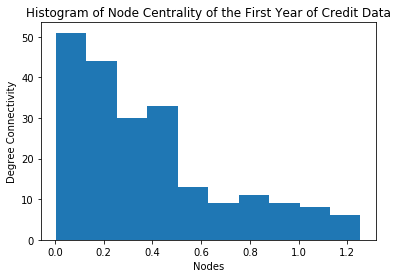

In [14]:
week_adj_matrices_all,n = load_data_to_adj_matrices('C:\Python36\Lib\site-packages\gym\envs\gym_compressor\complete_credit_data.csv','2000-01-05')
plt.hist(find_most_connected(week_adj_matrices_all,n))
plt.xlabel('Nodes')
plt.ylabel('Degree Connectivity')
plt.title('Histogram of Node Centrality of the First Year of Credit Data')
plt.show()

## Reward Structure

The reward structure of this problem is quite simple, our agent will recieve a reward of $-1$ for every time step it spends with total notional above the given threshold and positive 1 otherwise. Below is the "\_get\_reward" fucntion in our OpenAi Gym environment.

In [15]:
def _get_reward(self):
        """Reward is given for each timestep below the is_compressed threshold."""
        if self.is_compressed:
            return 1
        else:
            return -1

## Action Structure

As previously mentioned, minimizing the total notional amongst a set of banks $B$ and their respective edges $E$ while maintaining the amount owed from each bank to every other is a solved problem. It can be solved using the following linear programming problem:

\begin{equation} \label{eq1}
\begin{split}
\text{minimize } & \hat{u} \cdot e' \\
\text{subject to } & Qe' = v \\
& 0 \leq e' \leq e
\end{split}
\end{equation}

Where $\hat{u}$ is a vector of all 1's, $e'$ is the set of edges that would minimize total notional, $Q$ is an incidence matrix of our derivatives contract graph $G$ and $v$ is a vector representation of the total degree of each bank (which represents underlying value on each banks balance sheet).

To figure out which cycles can be compressed in order achieve the minimum notional solution to the above linear programming problem, one could simply solve the problem, and subtract the solution of the problem from the original adjacency matrix. I denote this as the "critical adjacency matrix". It is composed entirely of "critical cycles" or non-overlapping cycles that must be removed in order to completely conservatively compress a credit derivatives network graph. Say $n$ is the number of critical cycles. Action $n$ of our agent corresponds to subtracting the first $n$ critical cycles from the current adjacency matrix (the adjacency matrix upon which the agent acts (The critical cycles are ordered by the excess notional removed when they are compressed).

## Observation Structure

### State Observations

The observation structure is a bit more complicated, the agent observes the state it exists in which is the culmination of actions it can take, and contracts that have arrived during during the current episode. After it makes a specific action, the agent sees an adjacency matrix repesenting derivatives contracts that have originated up to timestep $t$ between the top $n$ banks with the highest node centrality. As an adjacency matrix is a very noisy way to view and try to discern patterns within a derivatives contract graph, I have looked quite seriously into using the first $k$ singular values of the adjacency matrix to derive a rank $k$ representation of the adjacency matrix.

### Action Observations

In addition, the agent observes the critical cycles of the adjacency matrix representing the culmination of derivatives contracts up to timestep $t$, these critical cycles are calculated by utilizing a conservative compression linear programming algorithm to find the graph that minimizes the notional excess of our derivatives contract graph. I then subtract this graph from the "current adjacency matrix" as described in "State Observations". The cycles of this graph consist entirely of "critical cycles" or cycles that should be removed in order to miniminze excess notional in the derivatives contract graph. Given $n$ critical cycles, our agent can choose between action $ 0 < i \leq n$ where choosing action $i$ runs the following algorithm, as described in (D’Errico and Roukny 2018, for the first $i$ critical cycles (The critical cycles are ordered by the excess notional removed when they are compressed):





In [23]:
def compress_critical_cycle(ccycle,adj_matrix):
    path = ccycle['cycle']
    path_edges = [(path[i-1],path[i]) for i in range(1,len(path))]
    min_edge = min([adj_matrix[edge] for edge in path_edges])
    for edge in path_edges:
        adj_matrix[edge] = adj_matrix[edge] - min_edge
    return adj_matrix

### Reward Observation

THe last observation to touch on is the observation that allows the agent to best discern how close it is to an optimal reward. Every timestep, our agent recieved information stating its excess\_percent which is the percent of counterfactual notional that is currently achieved by the current adjacency matrix. This is the same metric that will decide if an agent will recieve a reward of positive or negative 1 during a given timestep.

\_get\_state logic is displayed below

In [ ]:
    def _get_state(self):
        """Get the observation."""
        self.counterfactual_adj_matrix = self.counterfactual_adj_matrix + self.week_adj_matrices[self.curr_date]
        self.curr_adj_matrix = self.curr_adj_matrix + self.week_adj_matrices[self.curr_date]
        excess_percent = np.sum(self.curr_adj_matrix)/np.sum(self.counterfactual_adj_matrix)
        compress_res = compress_data(self.curr_adj_matrix)
        critical_matrix = compress_res["critical_matrix"]
        compressed_matrix = self.curr_adj_matrix - critical_matrix
        self.ccycles = critical_list_from_matrix(critical_matrix)
        return dict({"curr_adj_matrix":normalize_matrix(self.curr_adj_matrix),
                    "compressed_matrix":normalize_matrix(compressed_matrix),
                    "excess_percent":excess_percent})

# Results
Unfortunately, due to the time constraints of the semester, I was unable to build a deep learning agent to train within in the OpenAI Gym I intended to build. However, I was able to build the gym environment and to test various policies on it. For these tests, I used the 10 most connected banks and I used the timesteps of the 57 weeks from January 5th, 1999 to Febuary 8th, 2000. I tested 3 policies:
1. A policy in which the agent compresses all critical cycles left in the derivatives market's graph. At every timestep, this policy calculates the critical cycles of the graph and compresses all of them.
1. A policy in which the agent compresses 500 critical cycles left in the derivatives market's graph. At every timestep, this policy calculates the critical cycles of the graph and compresses all of them.
1. A policy in which the agent compresses a random number of cycles 

Below are the eliminate notional at each time step by each policy. The minimum notional achieved by the random policy uses an average of 100 random polices. The red line, denoted "minimum notional" calculated as the the minimum notional achieved if at the last time step, the algorithm described in Roukny and D'Errico is run. This is the minimum possible excess percent utilizing conservative compression. A compression policy can be evaluated by its distance towards this metric, which for this time interval, and this number of banks is about 44%.

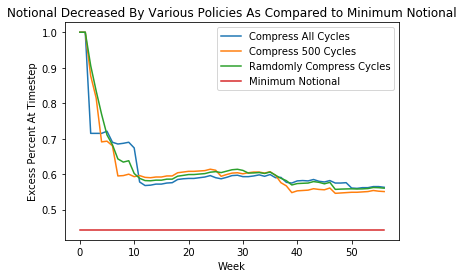

In [17]:
min_notional = 0.4428939458995277
min_notional_achieved_all_cycles = [1.0000,1.0000,0.7150,0.7150,0.7150,0.7210,0.6900,0.6850,0.6870,0.6900,0.6740,0.5780,0.5680,0.5690,0.5720,0.5720,0.5750,0.5760,0.5850,0.5870,0.5880,0.5880,0.5900,0.5920,0.5960,0.5900,0.5870,0.5910,0.5960,0.5970,0.5930,0.5930,0.5950,0.5980,0.5940,0.5990,0.5900,0.5910,0.5770,0.5750,0.5810,0.5820,0.5810,0.5850,0.5800,0.5780,0.5820,0.5750,0.5750,0.5760,0.5610,0.5600,0.5620,0.5620,0.5650,0.5650,0.5630]
min_notional_achieved_500_cycles = [1.0000,1.0000,0.8770,0.8150,0.6910,0.6930,0.6800,0.5950,0.5960,0.6000,0.5930,0.5960,0.5910,0.5900,0.5920,0.5920,0.5950,0.5950,0.6040,0.6060,0.6080,0.6080,0.6090,0.6100,0.6140,0.6110,0.5940,0.5990,0.6030,0.6040,0.6010,0.6040,0.6060,0.6060,0.6030,0.6070,0.5970,0.5760,0.5670,0.5480,0.5530,0.5540,0.5550,0.5590,0.5570,0.5560,0.5610,0.5460,0.5470,0.5480,0.5490,0.5490,0.5500,0.5510,0.5540,0.5520,0.5510]
min_notional_achieved_random_cycles = [1,1,0.905787879,0.834959596,0.769020202,0.710434343,0.68279798,0.642989899,0.634050505,0.637878788,0.602010101,0.588292929,0.581949495,0.581353535,0.583111111,0.583040404,0.585949495,0.585989899,0.594333333,0.596515152,0.598939394,0.598989899,0.600353535,0.601585859,0.605555556,0.607131313,0.604454545,0.608464646,0.612444444,0.61379798,0.610646465,0.603131313,0.603525253,0.604585859,0.601989899,0.606020202,0.597060606,0.588313131,0.581707071,0.569535354,0.573525253,0.574323232,0.574959596,0.579121212,0.577010101,0.572808081,0.576949495,0.55710101,0.557888889,0.558393939,0.55869697,0.558252525,0.558565657,0.559474747,0.562424242,0.56189899,0.560565657]

n_weeks = len(min_notional_achieved_all_cycles)
plt.plot(range(n_weeks), min_notional_achieved_all_cycles, label="Compress All Cycles")
plt.plot(range(n_weeks), min_notional_achieved_500_cycles, label="Compress 500 Cycles")
plt.plot(range(n_weeks), min_notional_achieved_random_cycles, label="Ramdomly Compress Cycles")
plt.plot(range(n_weeks),[min_notional]*n_weeks, label="Minimum Notional")
#plt.axis((0,n_weeks,0,1))
plt.title("Notional Decreased By Various Policies As Compared to Minimum Notional")
plt.ylabel("Excess Percent At Timestep")
plt.xlabel("Week")
plt.legend()
plt.show()

While it would be intuitive that compressing all cycles at every timestep decreases notional significantly, the figure above shows that this is not the case. In fact, there is a great deal of room between the minimum notional (44%) and the resulting notional from the three policies analyzed, which seem to have equivalent success. This "optimization gap" is nontrivial, as it leaves about 13 billion euros uncompressed in the european credit derivatives market. The lower level achieved by compressing only 500 cycles each timestep seems to suggest the presence of a "happy medium" between compressing all cycles and compressing no cycles that yields lower excess notional at the end of each episode (one round of compressing at every time step). This "happy medium" could likely be found by a reinforcement learning agent.

It is also noteworthy that there is a great deal of variation in results amongst the random agents 100 episodes. Below is a plot denoting the random agents average performance, its maximum performance, and its minimum performance.

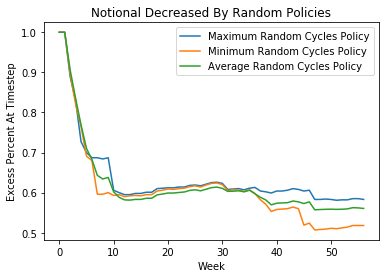

In [22]:
random_cycles_max = [1,1,0.889,0.83,0.727,0.7,0.687,0.687,0.684,0.687,0.606,0.6,0.595,0.595,0.598,0.598,0.601,0.601,0.61,0.611,0.612,0.612,0.614,0.614,0.618,0.619,0.617,0.621,0.625,0.626,0.623,0.608,0.609,0.61,0.607,0.611,0.613,0.604,0.602,0.599,0.604,0.604,0.606,0.61,0.608,0.604,0.606,0.583,0.583,0.584,0.583,0.581,0.582,0.582,0.585,0.585,0.583]
random_cycles_min = [1,1,0.896,0.821,0.765,0.691,0.68,0.596,0.596,0.6,0.593,0.595,0.59,0.592,0.593,0.592,0.595,0.595,0.604,0.606,0.609,0.608,0.61,0.611,0.615,0.617,0.614,0.619,0.623,0.624,0.62,0.605,0.607,0.606,0.603,0.607,0.598,0.582,0.571,0.553,0.558,0.559,0.56,0.564,0.56,0.519,0.524,0.507,0.508,0.509,0.511,0.51,0.512,0.514,0.518,0.518,0.518]
random_cycles_average = [1,1,0.905787879,0.834959596,0.769020202,0.710434343,0.68279798,0.642989899,0.634050505,0.637878788,0.602010101,0.588292929,0.581949495,0.581353535,0.583111111,0.583040404,0.585949495,0.585989899,0.594333333,0.596515152,0.598939394,0.598989899,0.600353535,0.601585859,0.605555556,0.607131313,0.604454545,0.608464646,0.612444444,0.61379798,0.610646465,0.603131313,0.603525253,0.604585859,0.601989899,0.606020202,0.597060606,0.588313131,0.581707071,0.569535354,0.573525253,0.574323232,0.574959596,0.579121212,0.577010101,0.572808081,0.576949495,0.55710101,0.557888889,0.558393939,0.55869697,0.558252525,0.558565657,0.559474747,0.562424242,0.56189899,0.560565657]

plt.plot(range(n_weeks), random_cycles_max, label="Maximum Random Cycles Policy")
plt.plot(range(n_weeks), random_cycles_min, label="Minimum Random Cycles Policy")
plt.plot(range(n_weeks), random_cycles_average, label="Average Random Cycles Policy")
plt.title("Notional Decreased By Random Policies")
plt.ylabel("Excess Percent At Timestep")
plt.xlabel("Week")
plt.legend()
plt.show()

Again, we notice quite a large "optimization gap" between poor performing random policies, and better performing random policies. It is also worth noting that the minimum random cycles policy performs significantly better than both the "compress all cycles" policy and the "compress 500 cycles" policy. This is a suprising result, as these more "intuitive" policies perform about as well as the average random agent, and much worse than some of the higher performing random agents. Neither policy's results are nearly close enough to the "minimum notional" line to have any practical utiliy but as I move forward with my research, I intend to build a learning agent that will learn a significantly better policy than randomly compressing, compressing 500 cycles every time step, or compressing all cycles at every timestep.

# Next Steps
1. Build a deep learning agent to play in this model, right now the cross entropy agent from the OpenAI Gym package that I am using has quite poor performance; I made this gym enviroment to test architectures with stronger pattern recognition abilities, and I certainly would like to test my environment on such architectures.
1. I have been playing quite a bit with the idea of sending the reinforcement learning agent information about only portions of the singular value decompisition of the "current state adjacency matrix". This would help accentuate patterns within the adjacency matrix amongst banks with very distinct trading patterns. Once I am able to begin to work more seriously on using a deep learning architecture for policy discovery this will definitly be the first mutation of the very noisy adjacency matrix I will try.